In [1]:
import nb_utils
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import traceback
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

Moving cwd to /store/CIA/js2164/repos/diffusion/score_sde_pytorch


In [2]:
def tflog2pandas(path):
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data

In [3]:
dims=[5, 10, 25, 50, 75, 100, 150, 200, 350, 500]

rec_errors=[]
for dim in dims:
    path = f'logs/VAE/mnist/kl_-1/latent_dim_{dim}'
    df=tflog2pandas(path)
    r = df[df.metric == 'val_loss'].min().value
    rec_errors.append(r)
rec_errors = np.stack(rec_errors)

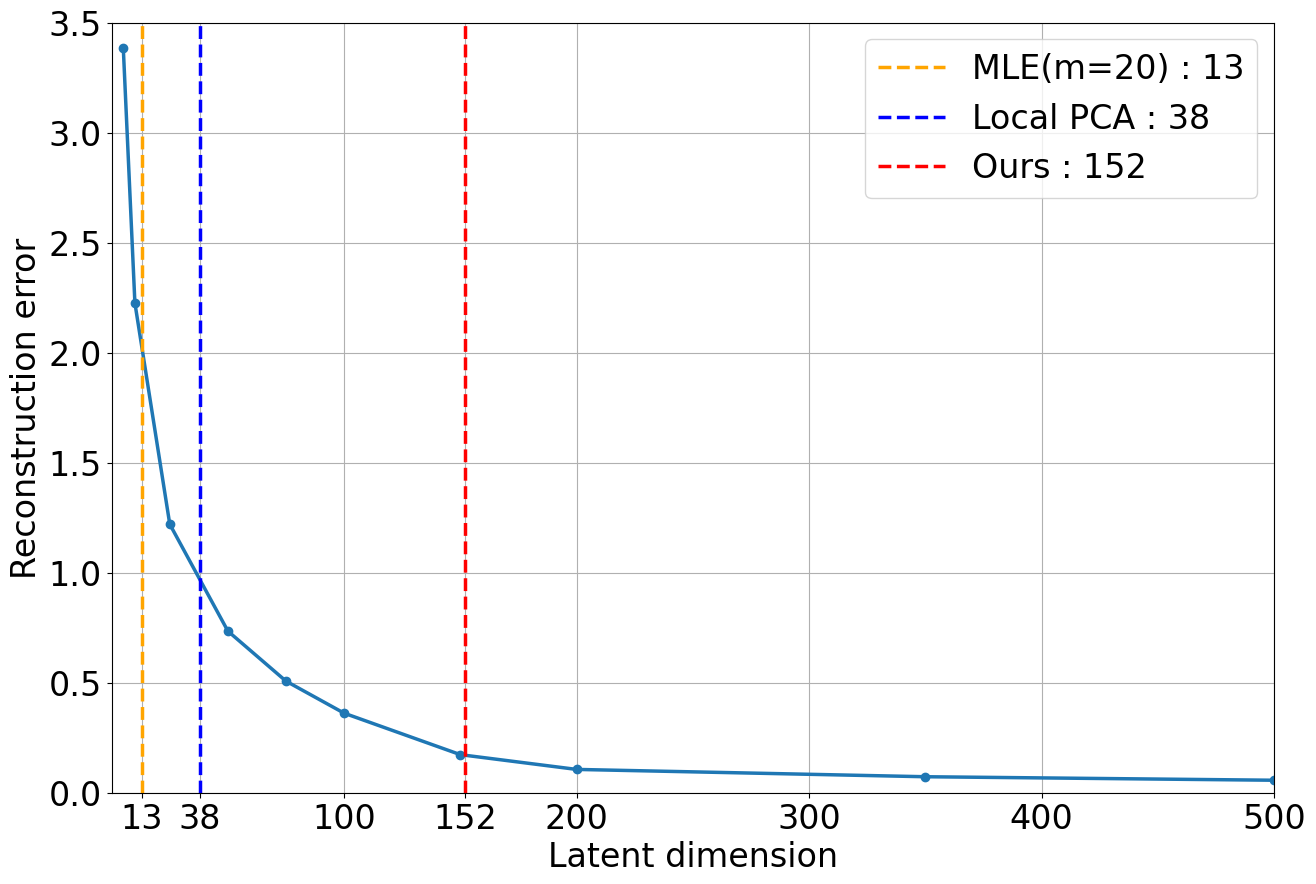

In [18]:
plt.rcParams.update({'font.size': 24})
#increase line thickness
plt.rcParams['lines.linewidth'] = 2.5
plt.figure(figsize=(15,10))
plt.plot(dims, rec_errors, 'o-')
plt.xlabel('Latent dimension')
plt.ylabel('Reconstruction error')
plt.grid(True)
plt.axvline(x=13, color='orange', linestyle='--', label='MLE(m=20) : 13')
plt.axvline(x=38, color='blue', linestyle='--', label='Local PCA : 38')
#plt.axvline(x=706, color='pink', linestyle='--', label='PPCA = 706')
plt.axvline(x=152, color='r', linestyle='--', label='Ours : 152')
plt.ylim((0, 3.5))  
plt.xlim((0, 500))
# add x ticks below vertical lines but also keep the old ones
plt.xticks(list(plt.xticks()[0][1:]) + [13, 38, 152])
plt.legend()
plt.savefig(f'figures/paper/mnist_autoencoder.png', bbox_inches='tight', dpi=300, facecolor='w')

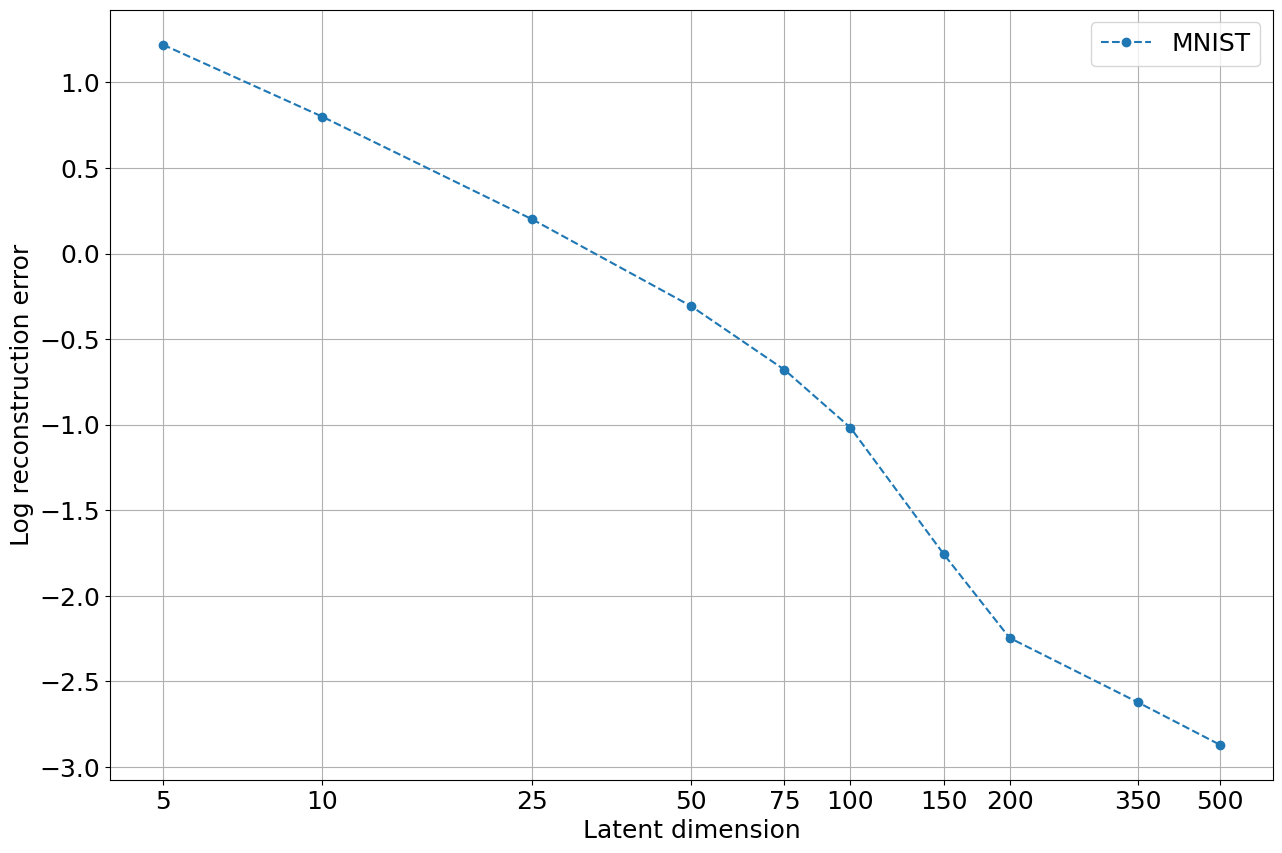

In [46]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(15,10))
plt.plot(np.log(dims), np.log(rec_errors), 'o--', label='MNIST')
plt.xticks(np.log(dims), dims)
plt.xlabel('Latent dimension')
plt.ylabel('Log reconstruction error')
plt.grid(True)
plt.legend()

In [30]:
def get_gradient(xs, ys):
    return np.gradient(ys, xs)

def get_second_derivative(xs, ys):
    return np.gradient(np.gradient(ys, xs), xs)

In [48]:
first_derivative = get_gradient(np.log(dims), np.log(rec_errors))
second_derivative = get_second_derivative(np.log(dims), np.log(rec_errors))

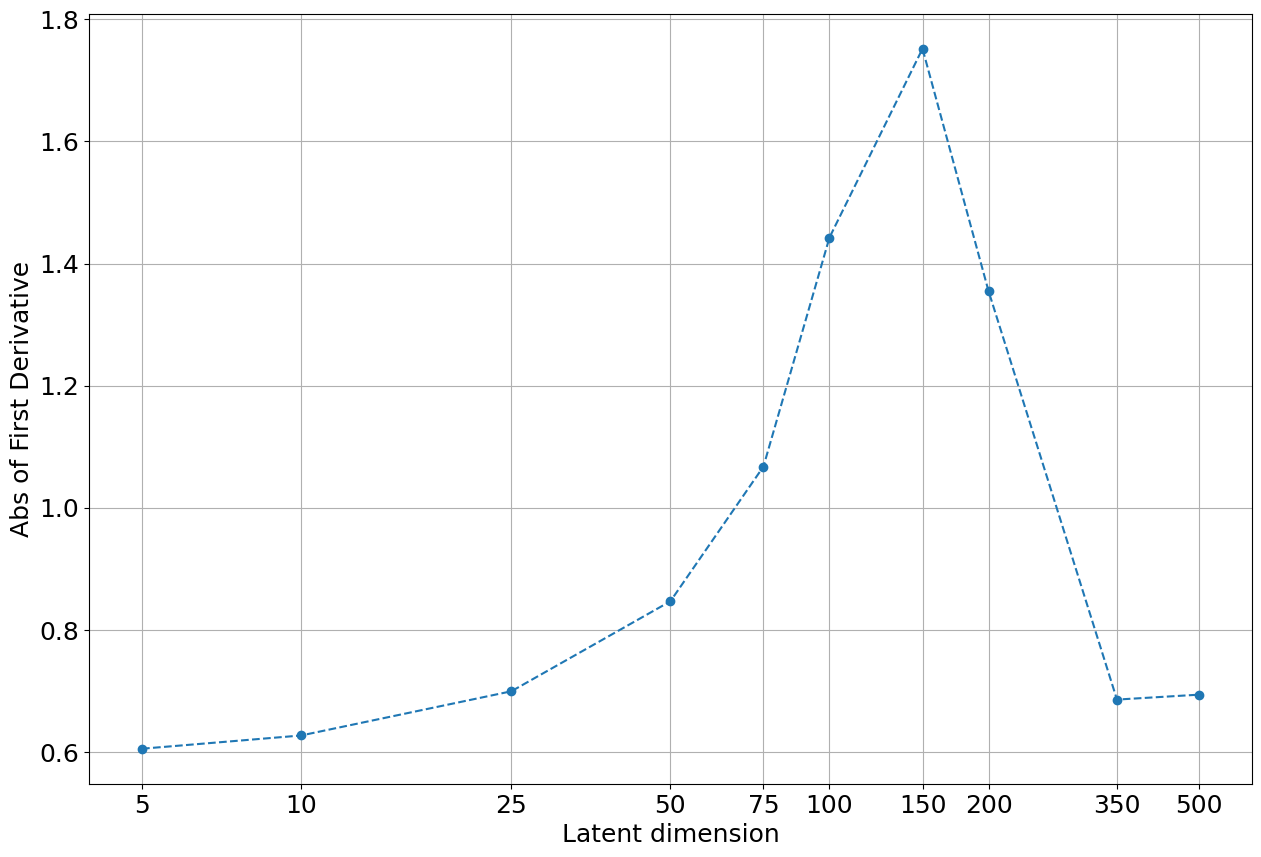

In [54]:
plt.figure(figsize=(15,10))
plt.plot(np.log(dims), np.abs(first_derivative), 'o--', label='First Derivative')
plt.xticks(np.log(dims), dims)
plt.xlabel('Latent dimension')
plt.ylabel('Abs of First Derivative')
plt.grid(True)
plt.show()

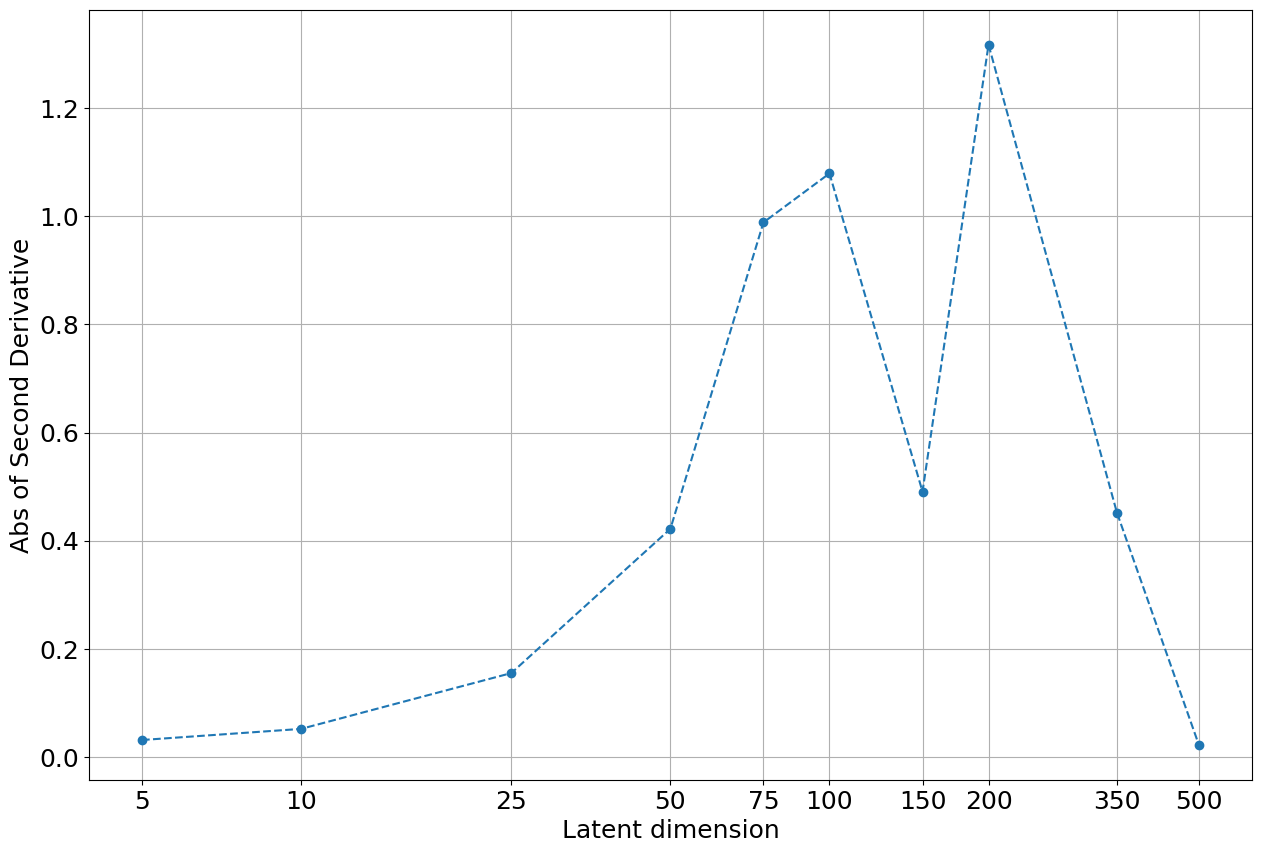

In [55]:
plt.figure(figsize=(15,10))
plt.plot(np.log(dims), np.abs(second_derivative), 'o--', label='Second Derivative')
plt.xticks(np.log(dims), dims)
plt.xlabel('Latent dimension')
plt.ylabel('Abs of Second Derivative')
plt.grid(True)
plt.show()